In [2]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.lines as lines


In [3]:
def mstar_from_stellarprops(rstar, logg):
    """Gives stellar mass from the rstar and logg
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
       OUTPUT:
         mstar - stellar mass [Msun]
    """
    # Convert logg and rstar into stellar mass assuming logg_sun=4.437
    mstar = 10.0**logg * rstar**2. / 10.0**4.437
    return mstar

def earthflux_at_period(rstar, logg, teff, period):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         period - Orbital Period [day]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Calculate semi-major axis [AU]
    semia = mstar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx

def earthflux_at_semia(rstar, logg, teff, semia):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         semia - Orbital semi-major axis [AU]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx


In [4]:
allStars = pd.read_csv("../stellarCatalogs/dr25_stellar_berger2019_dwarfs.txt")
# allStars = pd.read_csv("../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt")
print("allStars has " + str(len(allStars)) + " stars")
allStars = allStars[allStars.teff < 7300];
print("allStars has " + str(len(allStars)) + " stars after restricting to FGKM")


allStars has 105118 stars
allStars has 102071 stars after restricting to FGKM


In [5]:
innerHZ = earthflux_at_semia(1, 4.437, 5778.0, 0.75)
outerHZ = earthflux_at_semia(1, 4.437, 5778.0, 1.77)
print("HZ flux: " + str(innerHZ) + " to " + str(outerHZ))

HZ flux: 1.7777777777777777 to 0.3191930798940279


In [6]:
Ts = allStars.teff - 5780
KoppHzIn = 1.0140 + 8.1774e-5*Ts + 1.7063e-9*Ts**2 + -4.3241e-12*Ts**3 + -6.6462e-16*Ts**4
KoppHzOut = 0.3438 + 5.8942e-5*Ts + 1.6558e-9*Ts**2 + -3.0045e-12*Ts**3 + -5.2983e-16*Ts**4

In [7]:
flux1Day = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 1)
flux400Day = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 400)
flux473Day = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 473)
flux500Day = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 500)
flux710Day = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 710)
fluxSAG13HzHigh = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 222.65)
fluxSAG13HzLow = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 808.84)
fluxZetaEarthHigh = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 0.8*365.4)
fluxZetaEarthLow = earthflux_at_period(allStars.radius, allStars.logg, allStars.teff, 1.2*365.4)


In [8]:
fs = (allStars.teff >= 6000) & (allStars.teff < 7300)
gs = (allStars.teff >= 5300) & (allStars.teff < 6000)
ks = (allStars.teff >= 3900) & (allStars.teff < 5300)
ms = (allStars.teff >= 2400) & (allStars.teff < 3900)

In [9]:
keplerDurationDays = 1421
keplerDurationDays/2

710.5

In [10]:
dr25Pcs = pd.read_csv("koiCatalogs/dr25_GK_PCs.csv")
dr25Pcs["insolation"] = earthflux_at_period(dr25Pcs.radius, dr25Pcs.logg, dr25Pcs.teff, dr25Pcs.koi_period)
smallPcs = dr25Pcs[dr25Pcs.corrected_prad < 2.5]

In [11]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

teffColors = pd.read_csv("../stellarCatalogs/teffColorTable.txt", delim_whitespace=True, comment='#', dtype={"bitcode":object})
teffColors = teffColors[teffColors.type=="2deg"]
# interpolate teff onto RGB
allStars["teffR"] = np.interp(np.sort(allStars.teff), teffColors.temp, teffColors.R)
allStars["teffG"] = np.interp(np.sort(allStars.teff), teffColors.temp, teffColors.G)
allStars["teffB"] = np.interp(np.sort(allStars.teff), teffColors.temp, teffColors.B)

colormat = np.transpose([allStars["teffR"],allStars["teffG"],allStars["teffB"]])
teffCmap = ListedColormap(colormat, name='teffCmap')

In [12]:
def plot_insolation(stars, flux, plotExtra=False):
    capsize = 0

    plt.figure(figsize=(20,10));
    plt.errorbar((flux1Day+flux)/2, stars.teff, xerr=(flux-flux1Day)/2, 
                 c="grey", fmt="none", alpha=0.03, zorder=1)

    plt.scatter(flux1Day, stars.teff, cmap=teffCmap, c=stars.teff, s=1, alpha=0.1, zorder=5)
    sc = plt.scatter(flux, stars.teff, cmap=teffCmap, c=stars.teff, s=1, alpha=0.1, zorder=5)
    # clb = plt.colorbar(sc)
    # ebRange[0].set_color(teffCmap(stars.teff))
    
    if plotExtra:
        plt.scatter(fluxSAG13HzLow, allStars.teff, cmap=teffCmap, c='g', s=1, alpha=0.1, zorder=7)
        plt.scatter(fluxSAG13HzHigh, allStars.teff, cmap=teffCmap, c='g', s=1, alpha=0.1, zorder=7)
        plt.scatter(fluxZetaEarthLow, allStars.teff, cmap=teffCmap, c='b', s=1, alpha=0.1, zorder=7)
        plt.scatter(fluxZetaEarthHigh, allStars.teff, cmap=teffCmap, c='b', s=1, alpha=0.1, zorder=7)

    plt.plot([1, 1], [np.min(stars.teff), np.max(stars.teff)], color='r', zorder=10)
    plt.plot([innerHZ, innerHZ], [np.min(stars.teff), np.max(stars.teff)], color='r', linestyle='--', zorder=10)
    plt.plot([outerHZ, outerHZ], [np.min(stars.teff), np.max(stars.teff)], color='r', linestyle='--', zorder=10)
    plt.plot([np.min(outerHZ), np.max(innerHZ)], [5778.0, 5778.0], color='m', linestyle='--', zorder=10)
    plt.plot([np.min(flux710Day), np.max(flux1Day)], [6000, 6000], color='w', linestyle='-', alpha=0.5, zorder=10)
    plt.plot([np.min(flux710Day), np.max(flux1Day)], [5300, 5300], color='w', linestyle='-', alpha=0.5, zorder=10)
    plt.plot([np.min(flux710Day), np.max(flux1Day)], [3900, 3900], color='w', linestyle='-', alpha=0.5, zorder=10)

    plt.scatter(KoppHzIn, stars.teff, color='c', s=1, zorder=11)
    plt.scatter(KoppHzOut, stars.teff, color='c', s=1, zorder=11)

    scp=plt.scatter(smallPcs.insolation, smallPcs.teff, c=smallPcs.corrected_prad, 
                    s=10*smallPcs.corrected_prad, alpha=1, zorder=20)
    cbh = plt.colorbar(scp)
    cbh.ax.set_ylabel("planet radius", fontSize = 16);

    ax = plt.gca()
    ax.tick_params(axis = "both", labelsize = 16)

    xlim=plt.xlim();
    plt.xlim(xlim[1],0.01)
    plt.xscale('log');
    plt.xlabel('insolation flux', fontsize = 18);
    plt.ylabel('Teff', fontsize = 18);

    txtX = 3e-2
    txtDeltaY = 100
    ylim = plt.ylim();
    plt.text(txtX, 6000+txtDeltaY, "F", alpha=0.5, fontSize=24);
    plt.text(txtX, 5300+txtDeltaY, "G", alpha=0.5, fontSize=24);
    plt.text(txtX, 3900+txtDeltaY, "K", alpha=0.5, fontSize=24);
    plt.text(txtX, ylim[0]+txtDeltaY, "M", alpha=0.5, fontSize=24);


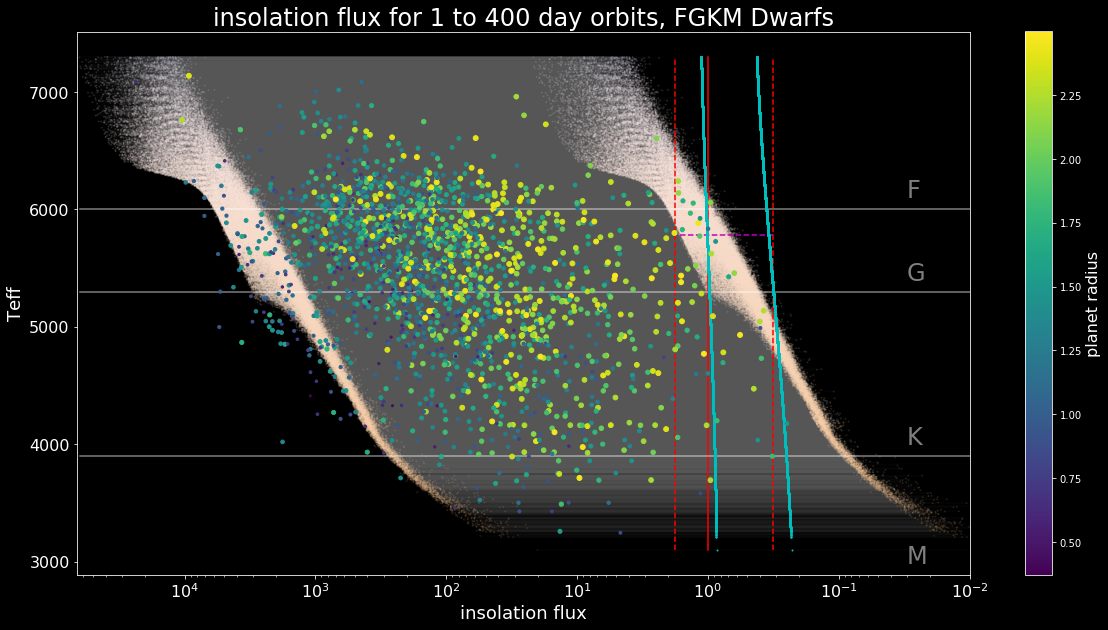

In [13]:
plt.style.use('dark_background')
plot_insolation(allStars, flux400Day)
plt.title('insolation flux for 1 to 400 day orbits, FGKM Dwarfs', fontsize = 24);


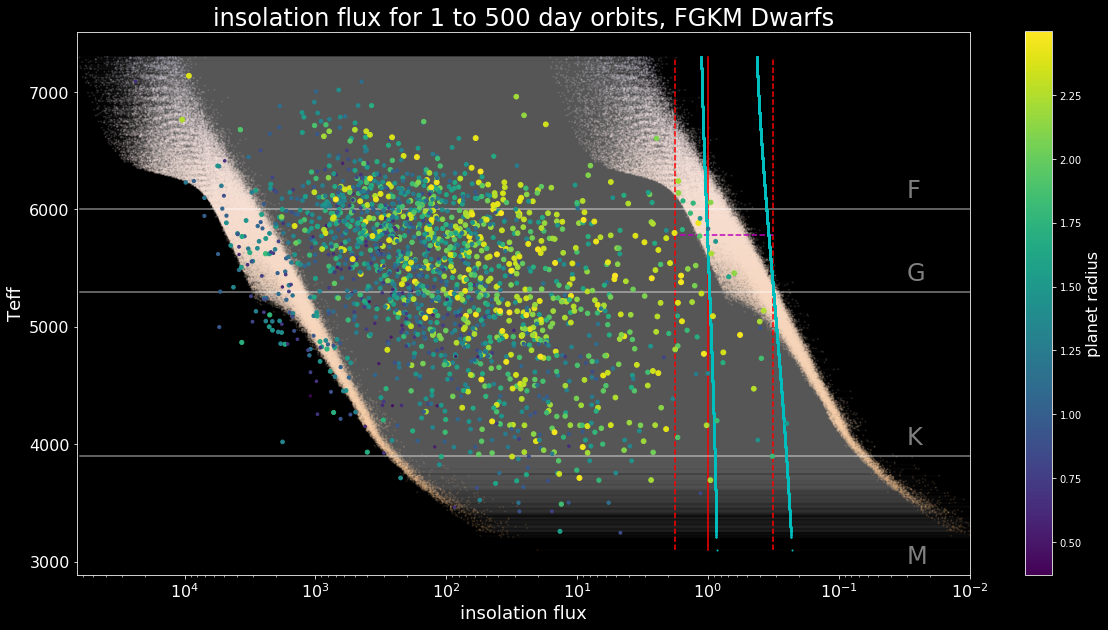

In [14]:
plt.style.use('dark_background')
plot_insolation(allStars, flux500Day)
plt.title('insolation flux for 1 to 500 day orbits, FGKM Dwarfs', fontsize = 24);


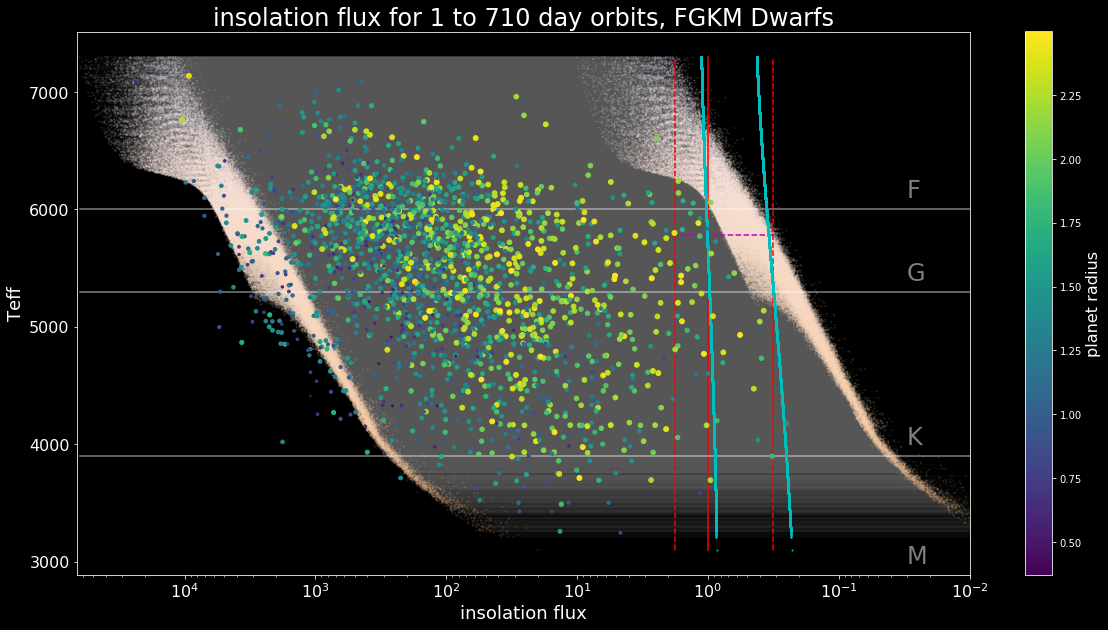

In [15]:
plt.style.use('dark_background')
plot_insolation(allStars, flux710Day)
plt.title('insolation flux for 1 to 710 day orbits, FGKM Dwarfs', fontsize = 24);


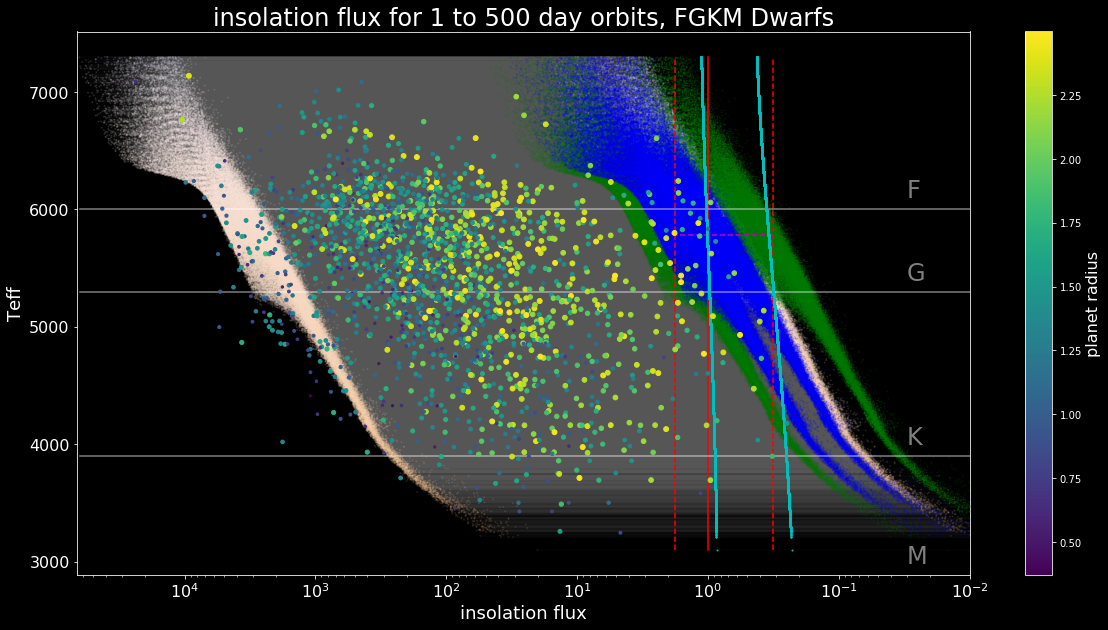

In [16]:
plt.style.use('dark_background')
plot_insolation(allStars, flux500Day, True)
plt.title('insolation flux for 1 to 500 day orbits, FGKM Dwarfs', fontsize = 24);


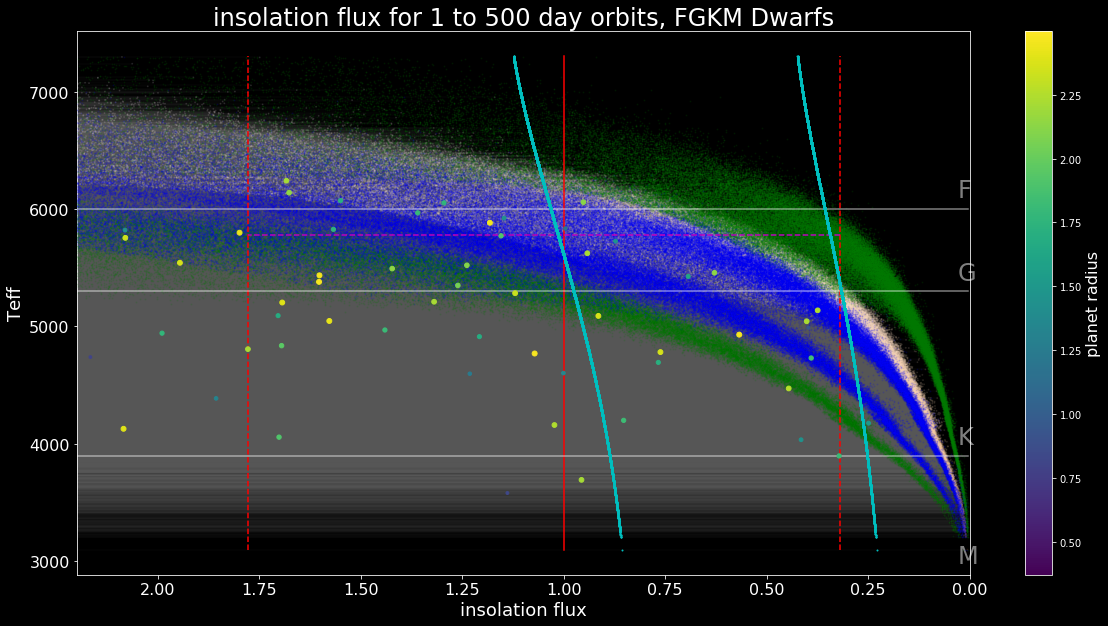

In [17]:
plt.style.use('dark_background')
plot_insolation(allStars, flux500Day, True)
plt.xscale('linear');
plt.xlim(2.2, 0);
plt.title('insolation flux for 1 to 500 day orbits, FGKM Dwarfs', fontsize = 24);


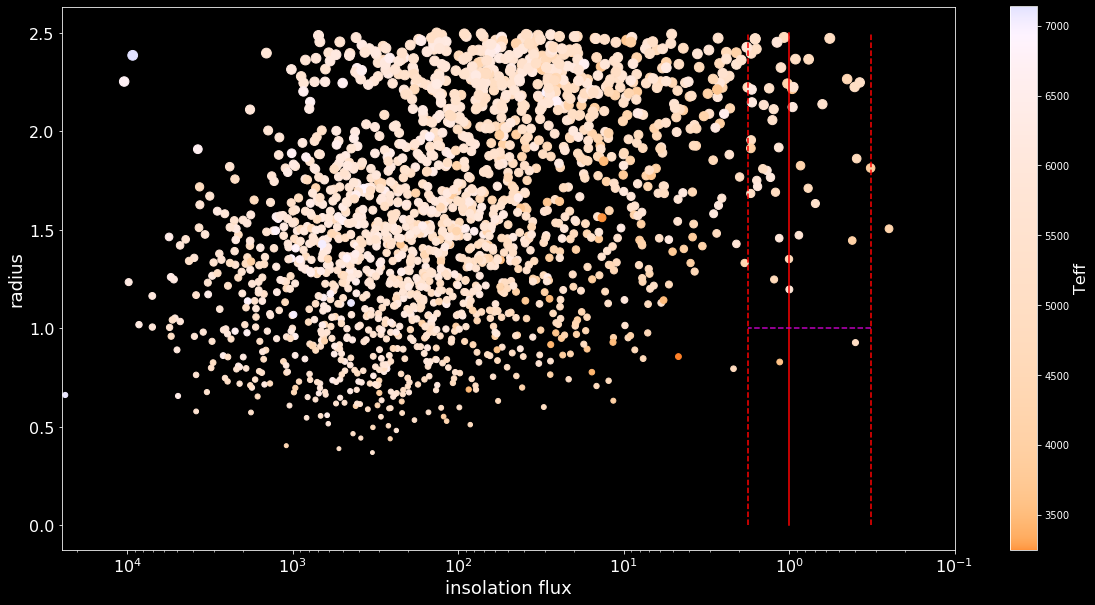

In [18]:
plt.figure(figsize=(20,10));
scp=plt.scatter(smallPcs.insolation, smallPcs.corrected_prad, cmap=teffCmap, c=smallPcs.teff, 
                s=40*smallPcs.corrected_prad, alpha=1)
cbh=plt.colorbar(scp)
cbh.ax.set_ylabel("Teff", fontSize = 16);

plt.plot([1, 1], [0, 2.5], color='r', zorder=10)
plt.plot([innerHZ, innerHZ], [0, 2.5], color='r', linestyle='--', zorder=10)
plt.plot([outerHZ, outerHZ], [0, 2.5], color='r', linestyle='--', zorder=10)
plt.plot([np.min(outerHZ), np.max(innerHZ)], [1,1], color='m', linestyle='--', zorder=10)

xlim=plt.xlim();
plt.xlim(xlim[1],0.1)

ax = plt.gca()
ax.tick_params(axis = "both", labelsize = 16)
plt.xscale('log');
plt.xlabel('insolation flux', fontsize = 18);
plt.ylabel('radius', fontsize = 18);
